In [105]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display
import os


from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm



In [106]:
class_names = ['NORMAL', 'PNEUMONIA']
def get_list_of_images(path):
    images = []
    for i in os.listdir(path):
        images.append(i)
    return images

In [107]:
files_list_normal_train = get_list_of_images('chest_xray/train/NORMAL')
files_list_pneumonia_train = get_list_of_images('chest_xray/train/PNEUMONIA')

files_list_normal_test = get_list_of_images('chest_xray/test/NORMAL')
files_list_pneumonia_test = get_list_of_images('chest_xray/test/PNEUMONIA')


In [108]:
print('Number of normal train images: ', len(files_list_normal_train))
print('Number of pneumonia train images: ', len(files_list_pneumonia_train))
print('Number of normal test images: ', len(files_list_normal_test))
print('Number of pneumonia test images: ', len(files_list_pneumonia_test))
print("***********************************************")
print('Total number of train images: ', len(files_list_normal_train) + len(files_list_pneumonia_train))
print('Total number of test images: ', len(files_list_normal_test) + len(files_list_pneumonia_test))
print("***********************************************")
print('Total number of images: ', len(files_list_normal_train) + len(files_list_pneumonia_train) + len(files_list_normal_test) + len(files_list_pneumonia_test))

Number of normal train images:  1349
Number of pneumonia train images:  3883
Number of normal test images:  234
Number of pneumonia test images:  390
***********************************************
Total number of train images:  5232
Total number of test images:  624
***********************************************
Total number of images:  5856


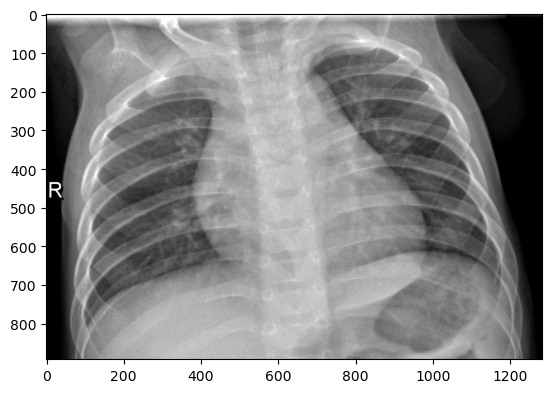

In [109]:
rand_img = np.random.randint(0, len(files_list_normal_train))
img = cv2.imread('chest_xray/train/NORMAL/' + files_list_normal_train[rand_img])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgplt = plt.imshow(img)
plt.show()

In [110]:
#Transformations

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])



In [111]:

train_data  =   datasets.ImageFolder('chest_xray/train', transform=train_transforms)
test_data =   datasets.ImageFolder('chest_xray/test', transform=test_transforms)


In [112]:
#Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)


In [113]:
class_names = train_data.classes
print(class_names)

['NORMAL', 'PNEUMONIA']


In [114]:
#Define the model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=8, 
                      kernel_size=(3, 3),
                      padding=0,
                      bias=False))
            #nn.BatchNorm2d(4),
        self.pool11 = nn.MaxPool2d(2, 2)
        
        #Convolution Block
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8,
                      out_channels=16,
                      kernel_size=(3, 3),
                      padding=0,
                      bias=False),
            nn.ReLU()
            #nn.BatchNorm2d(16)
            )
        
        #Transition Block
        
        self.pool22 = nn.MaxPool2d(2, 2)
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels = 10,
                      kernel_size = (1, 1),
                      padding=0,
                      bias=False),
                      #nn.BatchNorm2d(10),
                      nn.ReLU()
                      
                      )
        self.pool33 = nn.MaxPool2d(2, 2)
        
        #Convolution Block
        
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size = (1,1),
                      padding = 0,
                      bias = False),
            #nn.BatchNorm2d(10)
            nn.ReLU())
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10,
                      out_channels=32,
                      kernel_size = (1,1),
                      padding = 0,
                      bias = False),
            #nn.BatchNorm2d(32)
            nn.ReLU())
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=10,
                      kernel_size = (1,1),
                      padding = 0,
                      bias = False),
            nn.ReLU(),)
            #nn.BatchNorm2d(10))
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size=(3,3),
                      padding=0,
                      bias=False),
            nn.ReLU())
            #nn.BatchNorm2d(10)
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10,
                      out_channels= 32,
                      kernel_size=(1,1),
                      padding = 0,
                      bias=False),
            #nn.BatchNorm2d(32)
            nn.ReLU())
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=10,
                      kernel_size=(1,1),
                      padding=0,
                      bias=False),
            nn.ReLU())
            #nn.BatchNorm2d(10)
            
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels=14,kernel_size=(3,3),padding=0,bias=False),
            nn.ReLU()
            #nn.BatchNorm2d(14)
            )
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14,
                      out_channels = 16,
                      kernel_size=(3,3),
                      padding = 0,
                      bias = False),
            nn.ReLU())
            #nn.BatchNorm2d(16))        
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4),
            
                
            )
        self.convblockout  = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels = 2,
                      kernel_size = (4,4),padding=0,bias=False),
            )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [115]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
         MaxPool2d-2          [-1, 8, 111, 111]               0
            Conv2d-3         [-1, 16, 109, 109]           1,152
              ReLU-4         [-1, 16, 109, 109]               0
         MaxPool2d-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 10, 54, 54]             160
              ReLU-7           [-1, 10, 54, 54]               0
         MaxPool2d-8           [-1, 10, 27, 27]               0
            Conv2d-9           [-1, 10, 27, 27]             100
             ReLU-10           [-1, 10, 27, 27]               0
           Conv2d-11           [-1, 32, 27, 27]             320
             ReLU-12           [-1, 32, 27, 27]               0
           Conv2d-13           [-1, 10, 27, 27]             320
             ReLU-14           [-1

In [116]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [117]:
def train(model,device,train_loader,optimizer,epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [118]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    test_losses.append(test_loss)

    print(

        f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n')

In [119]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

In [120]:
for epoch in range(1, 20):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print("LR:", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

EPOCH: 1


  0%|          | 0/327 [00:00<?, ?it/s]


ValueError: Expected input batch_size (64) to match target batch_size (16).